## Dependencias 

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from varclushi import VarClusHi
from CreditScoringToolkit import frequency_table,DiscreteNormalizer
from functools import reduce 
from glob import glob 
from datetime import date,datetime 
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
pd.set_option('display.float_format',lambda x: '%.2f'%x)

## Sesión de Spark

In [104]:
findspark.init()
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

25/05/13 20:12:32 WARN Utils: Your hostname, MacBook-Air-de-Jose-2.local resolves to a loopback address: 127.0.0.1; using 10.104.46.239 instead (on interface en0)
25/05/13 20:12:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/13 20:12:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Lectura de datos 

In [3]:
path = '../data/ibm_card_txn/*.csv'

In [5]:
archivos = glob(path)

In [92]:
def limpiar_datos(arch:str)->pd.DataFrame:
    df = pd.read_csv(arch,dtype=str)
    df['Amount'] = pd.to_numeric(df['Amount'].map(lambda x:x.replace('$','')),errors='coerce')
    df = df.loc[df['Amount']>0].reset_index(drop=True)
    df['fecha'] = df[['Year','Month','Day']].astype(int).apply(lambda x:date(*x),axis=1)
    df['fecha']= pd.to_datetime(df['fecha'].map(lambda x:x.strftime('%Y-%m-%d '))+df['Time'])

    # Filter only the 50 states 2 char code of the US
    us_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
                'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
                'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
                'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
                'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

    # Check which transactions have valid US state codes
    df = df.loc[df['Merchant State'].isin(us_states)].reset_index(drop=True)
    df['id_txn'] = df[['User','Card']].apply("-".join,axis=1)
    df = df.loc[df['Errors?'].isnull()].reset_index(drop=True)
    df['Is Fraud?'] = (df['Is Fraud?']=='Yes').astype(int)
    fuera = ['User', 'Card', 'Year', 'Month', 'Day', 'Time','Errors?','Merchant Name','Merchant City','Zip']
    df.drop(fuera,axis=1,inplace=True)
    df.columns = ['c_amount','d_txn_type','d_state','d_mcc','tgt_fraud','dt_fecha','id_txn']
    return df

In [78]:
df = pd.concat([limpiar_datos(a) for a in archivos[:]],ignore_index=True)

/var/folders/y_/qfyfmtlx0dd71kh2qt_dvv100000gn/T/ipykernel_3998/2679794581.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fecha']= pd.to_datetime(df['fecha'].map(lambda x:x.strftime('%Y-%m-%d '))+df['Time'])


In [109]:
df = pd.read_parquet('../data/txn.parquet')

In [110]:
df.to_csv('../data/txn.csv',index=False)

In [111]:
df = spark.read.csv('../data/txn.csv',inferSchema=True,header=True)
df.printSchema()

root
 |-- c_amount: double (nullable = true)
 |-- d_txn_type: string (nullable = true)
 |-- d_state: string (nullable = true)
 |-- d_mcc: integer (nullable = true)
 |-- tgt_fraud: integer (nullable = true)
 |-- dt_fecha: timestamp (nullable = true)
 |-- id_txn: string (nullable = true)



In [112]:
type(df)

pyspark.sql.dataframe.DataFrame

In [113]:
sql = SQLContext(spark)

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [114]:
df.registerTempTable('tabla')

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


## Ingeniería de características 

In [122]:
query = """
 select *,
 avg(c_amount) over (partition by id_txn order by dt_fecha desc rows between 1 following and 30 following) as avg_amnt_bwd_30,
 avg(unix_timestamp(dt_fecha) - lag(unix_timestamp(dt_fecha)) over (partition by id_txn order by dt_fecha)) over (partition by id_txn order by dt_fecha desc rows between 1 following and 30 following) as avg_time_diff_bwd_30
 from tabla
"""

In [123]:
df = sql.sql(query)

In [127]:
df.coalesce(1).write.parquet('../data/complete_txn.parquet')

In [158]:
df = pd.read_parquet('../data/complete_txn.parquet/')

In [129]:
df.shape

(19947462, 9)

In [130]:
df.head()

,c_amount,d_txn_type,d_state,d_mcc,tgt_fraud,dt_fecha,id_txn,avg_amnt_bwd_30,avg_time_diff_bwd_30
0,84.76,Chip Transaction,FL,5499,0,2020-02-22 16:50:00,100-3,47.914667,455030.0
1,69.00,Chip Transaction,FL,5499,0,2020-02-22 16:34:00,100-3,46.113000,429620.0
2,3.20,Chip Transaction,FL,7538,0,2020-02-07 21:28:00,100-3,46.331000,446686.0
3,10.97,Chip Transaction,FL,7542,0,2020-02-06 20:41:00,100-3,47.205667,437246.0
4,68.17,Chip Transaction,FL,6300,0,2020-01-31 15:39:00,100-3,46.352333,469330.0


In [159]:
df['c_ratio_amount_prev_30'] = df['c_amount']/df['avg_amnt_bwd_30']

In [160]:
df = df.rename(columns={'avg_time_diff_bwd_30':'c_avg_time_diff_bwd_30',
                        'avg_amnt_bwd_30':'c_avg_amnt_bwd_30'
                        })

In [161]:
df.head()

,c_amount,d_txn_type,d_state,d_mcc,tgt_fraud,dt_fecha,id_txn,c_avg_amnt_bwd_30,c_avg_time_diff_bwd_30,c_ratio_amount_prev_30
0,84.76,Chip Transaction,FL,5499,0,2020-02-22 16:50:00,100-3,47.91,455030.00,1.77
1,69.00,Chip Transaction,FL,5499,0,2020-02-22 16:34:00,100-3,46.11,429620.00,1.50
2,3.20,Chip Transaction,FL,7538,0,2020-02-07 21:28:00,100-3,46.33,446686.00,0.07
3,10.97,Chip Transaction,FL,7542,0,2020-02-06 20:41:00,100-3,47.21,437246.00,0.23
4,68.17,Chip Transaction,FL,6300,0,2020-01-31 15:39:00,100-3,46.35,469330.00,1.47


## Naturaleza de las variables 

In [162]:
varc = [v for v in df.columns if v[:2]=='c_']
vard = [v for v in df.columns if v[:2]=='d_']
vart = ['tgt_fraud']
um = ['id_txn']
len(varc),len(vard)

(4, 3)

In [163]:
for v in varc:
    df[v] = pd.to_numeric(df[v],errors='coerce')
for v in vard:
    df[v] = df[v].fillna('MISSING').astype(str)

## Particion de datos  

In [164]:
train,valid = train_test_split(df,test_size=0.3,random_state=2014)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((13963223, 10), (5984239, 10))

## Análisis exploratorio de datos 

### Continuo

#### Ausentes 

In [165]:
miss = (train[varc].isnull().sum()/len(train)).to_frame('pct_miss')
miss

,pct_miss
c_amount,0.00
c_avg_amnt_bwd_30,0.00
c_avg_time_diff_bwd_30,0.00
c_ratio_amount_prev_30,0.00


In [166]:
train = train.dropna().reset_index(drop=True)

#### Varianza 

In [167]:
vt = VarianceThreshold(threshold=0)
vt.fit(train[varc])

VarianceThreshold(threshold=0)

In [168]:
fuera = [v for v,s in zip(varc,vt.get_support()) if not s]
print(fuera)
varc = [v for v in varc if v not in fuera]
train.drop(columns=fuera,inplace=True)

[]


#### Extremos 

In [169]:
display(train[varc].describe())
for v,li,ls in train[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[v] = train[v].clip(lower=li,upper=ls)
display(train[varc].describe())

,c_amount,c_avg_amnt_bwd_30,c_avg_time_diff_bwd_30,c_ratio_amount_prev_30
count,13954636.00,13954636.00,13954636.00,13954636.00
mean,50.18,50.29,79421.85,1.06
std,71.74,26.37,139200.37,1.58
min,0.01,0.14,0.00,0.00
25%,10.21,31.95,36776.00,0.25
50%,32.19,45.64,58342.00,0.71
75%,68.61,63.44,96222.00,1.37
max,6820.20,1605.22,44965740.00,1187.59


,c_amount,c_avg_amnt_bwd_30,c_avg_time_diff_bwd_30,c_ratio_amount_prev_30
count,13954636.00,13954636.00,13954636.00,13954636.00
mean,48.01,50.05,76798.66,1.01
std,53.17,24.95,59765.33,1.09
min,0.62,10.36,13668.00,0.02
25%,10.21,31.95,36776.00,0.25
50%,32.19,45.64,58342.00,0.71
75%,68.61,63.44,96222.00,1.37
max,310.49,133.98,334500.00,6.39


#### Multicolinealidad 

,c_amount,c_avg_amnt_bwd_30,c_avg_time_diff_bwd_30,c_ratio_amount_prev_30
c_amount,1.00,0.34,-0.01,0.82
c_avg_amnt_bwd_30,0.34,1.00,-0.02,-0.08
c_avg_time_diff_bwd_30,-0.01,-0.02,1.00,0.00
c_ratio_amount_prev_30,0.82,-0.08,0.00,1.00


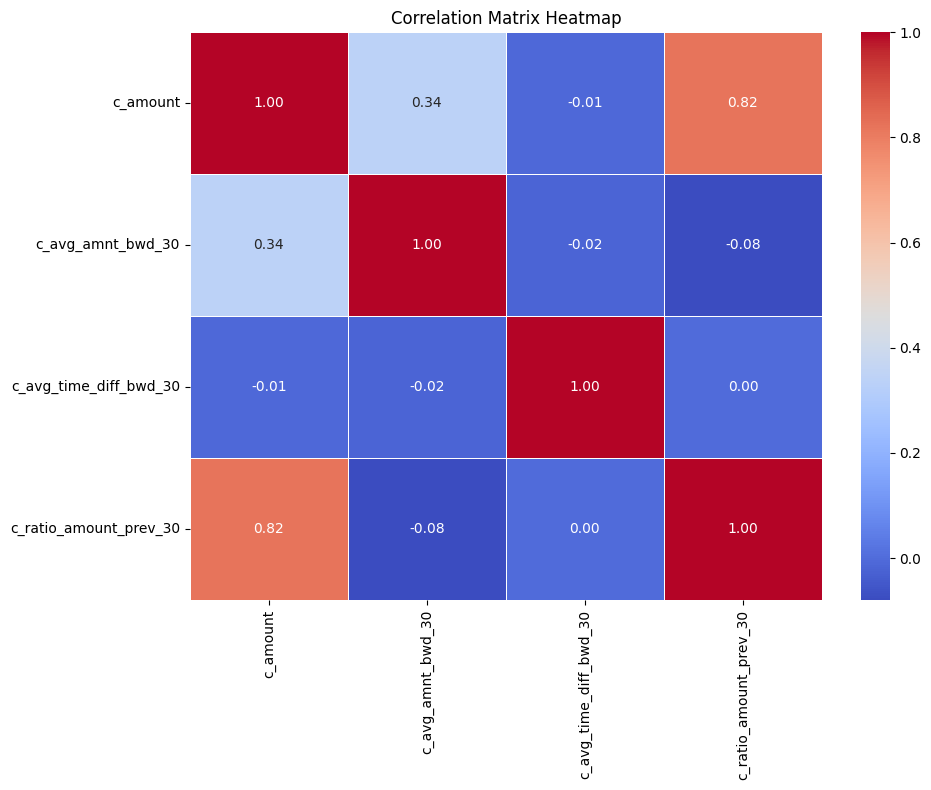

In [170]:
corr_matrix = train[varc].corr().round(2)
display(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

In [171]:
vc = VarClusHi(df=train,feat_list=varc).varclus()
rs = vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])
display(rs)
mc = list(rs.groupby('Cluster').first()['Variable'])
mc

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
1,0,c_ratio_amount_prev_30,0.91,0.01,0.09
0,0,c_amount,0.91,0.11,0.10
2,1,c_avg_time_diff_bwd_30,1.00,0.00,0.00
3,2,c_avg_amnt_bwd_30,1.00,0.02,0.00


['c_ratio_amount_prev_30', 'c_avg_time_diff_bwd_30', 'c_avg_amnt_bwd_30']

#### Distribuciones 

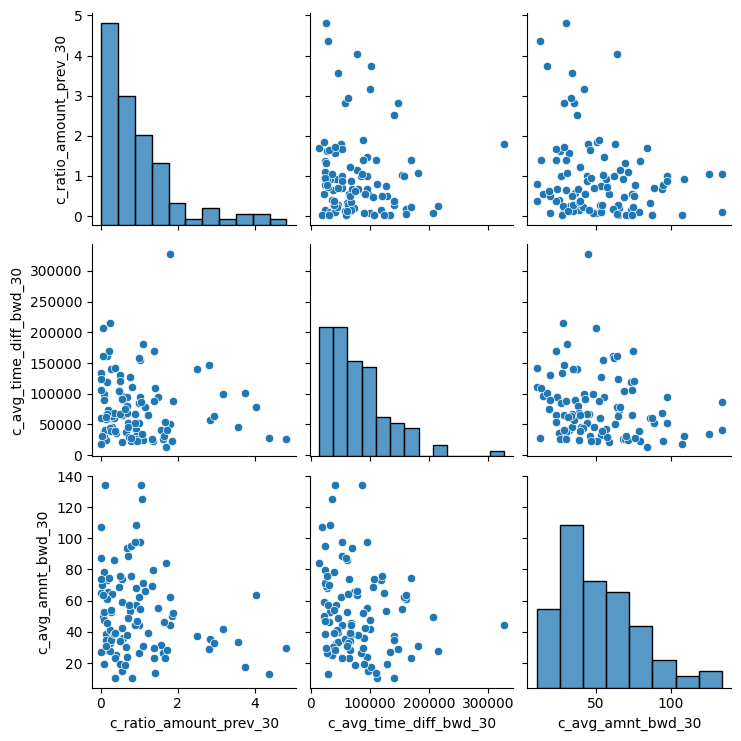

In [172]:
sns.pairplot(train[mc].sample(100))

### Discreto

#### Frecuencias 

In [173]:
frequency_table(train,vard+vart)

**** Frequency Table for d_txn_type ****

                   Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_txn_type                                                                 
Chip Transaction      4053115        0.29          4053115             0.29
Swipe Transaction     9901521        0.71         13954636             1.00




**** Frequency Table for d_state ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_state                                                          
AK             9894        0.00             9894             0.00
AL           221954        0.02           231848             0.02
AR           146195        0.01           378043             0.03
AZ           229093        0.02           607136             0.04
CA          1681855        0.12          2288991             0.16
CO           179323        0.01          2468314             0.18
CT           141832        0.01          2610146             0.19
DE            444

#### Normalización 

In [174]:
dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='OTROS')
dn.fit(train[vard])
train_norm = dn.transform(train[vard])
frequency_table(train_norm,vard)

**** Frequency Table for d_txn_type ****

                   Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_txn_type                                                                 
Chip Transaction      4053115        0.29          4053115             0.29
Swipe Transaction     9901521        0.71         13954636             1.00




**** Frequency Table for d_state ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_state                                                          
CA          1681855        0.12          1681855             0.12
OTROS      12272781        0.88         13954636             1.00




**** Frequency Table for d_mcc ****

       Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_mcc                                                          
5411      1959785        0.14          1959785             0.14
5499      1460362        0.10          3420147             0.25
5541      1427626        0.10          4847773    

In [175]:
fuera = [v for v in train_norm.columns if train_norm[v].nunique() == 1]
print(fuera)
vard = [v for v in vard if v not in fuera]
dn.fit(train_norm[vard])

[]


#### Encoding 

In [177]:
oh = OneHotEncoder(sparse_output=False,drop='if_binary')
oh.fit(train_norm[vard])
varoh = list(oh.get_feature_names_out(vard))
print(varoh)
train[varoh] = oh.transform(train_norm[vard])

['d_txn_type_Swipe Transaction', 'd_state_OTROS', 'd_mcc_5411', 'd_mcc_5499', 'd_mcc_5541', 'd_mcc_OTROS']


## Conjunto de entrenamiento $S_n = \{(x^{(i)},y^{(i)})|i=1,2,\dots,n\}$

In [178]:
Sn = train[um+mc+varoh+vart].copy()
Sn.head()

,id_txn,c_ratio_amount_prev_30,c_avg_time_diff_bwd_30,c_avg_amnt_bwd_30,d_txn_type_Swipe Transaction,d_state_OTROS,d_mcc_5411,d_mcc_5499,d_mcc_5541,d_mcc_OTROS,tgt_fraud
0,965-2,0.73,78938.00,57.39,1.00,1.00,0.00,0.00,1.00,0.00,0
1,847-3,0.56,154966.00,44.89,1.00,1.00,0.00,0.00,0.00,1.00,0
2,1150-1,0.04,28782.00,59.74,1.00,0.00,0.00,1.00,0.00,0.00,0
3,1993-5,2.00,204430.00,70.76,0.00,1.00,0.00,0.00,0.00,1.00,0
4,36-1,0.02,159532.00,31.84,0.00,0.00,0.00,0.00,0.00,1.00,0


In [179]:
frequency_table(Sn,vart)

**** Frequency Table for tgt_fraud ****

           Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
tgt_fraud                                                          
0            13951393        1.00         13951393             1.00
1                3243        0.00         13954636             1.00






## Aprendizaje 

In [180]:
var = mc+varoh

### Híperparametrización 

In [181]:
dt = DecisionTreeClassifier()

In [182]:
# Espacio Híper-paramétrico
hparam_grid = {
    'criterion': ['gini','entropy','log_loss'],
    'splitter': ['best','random'],
    'max_depth': np.arange(2,5),
    'min_samples_split': np.arange(0.1,0.2,0.01),
    'min_samples_leaf': np.arange(0.1,0.2,0.01),
    'max_features': ['sqrt','log2']
}
reduce(lambda x,y: x*y, [len(hparam_grid[k]) for k in hparam_grid])

3600

In [187]:
grid = RandomizedSearchCV(estimator=dt,
                    param_distributions=hparam_grid,
                    cv=5,
                    scoring='roc_auc',
                    n_iter=10,
                    n_jobs=-1,
                    verbose=1)
grid.fit(Sn[var],Sn[vart[0]])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(criterion='log_loss',
                                                    max_depth=np.int64(2),
                                                    max_features='log2',
                                                    min_samples_leaf=np.float64(0.17999999999999997),
                                                    min_samples_split=np.float64(0.15999999999999998),
                                                    splitter='random'),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([2, 3, 4]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                                        'min_samples_split': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc', verbose=1)

In [188]:
grid.best_score_

np.float64(0.6840363302907696)

In [189]:
dt = grid.best_estimator_

In [190]:
dt

DecisionTreeClassifier(criterion='log_loss', max_depth=np.int64(4),
                       max_features='sqrt',
                       min_samples_leaf=np.float64(0.13999999999999999),
                       min_samples_split=np.float64(0.1))

### Entrenamiento 

In [191]:
dt.fit(Sn[var],Sn[vart[0]])

DecisionTreeClassifier(criterion='log_loss', max_depth=np.int64(4),
                       max_features='sqrt',
                       min_samples_leaf=np.float64(0.13999999999999999),
                       min_samples_split=np.float64(0.1))

[Text(0.5, 0.8333333333333334, 'd_txn_type_Swipe Transaction <= 0.5\nlog_loss = 0.003\nsamples = 100.0%\nvalue = [1.0, 0.0]'),
 Text(0.25, 0.5, 'c_avg_time_diff_bwd_30 <= 67033.668\nlog_loss = 0.001\nsamples = 29.0%\nvalue = [1.0, 0.0]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'log_loss = 0.001\nsamples = 14.5%\nvalue = [1.0, 0.0]'),
 Text(0.375, 0.16666666666666666, 'log_loss = 0.002\nsamples = 14.6%\nvalue = [1.0, 0.0]'),
 Text(0.75, 0.5, 'd_mcc_OTROS <= 0.5\nlog_loss = 0.004\nsamples = 71.0%\nvalue = [1.0, 0.0]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'log_loss = 0.001\nsamples = 24.6%\nvalue = [1.0, 0.0]'),
 Text(0.875, 0.16666666666666666, 'log_loss = 0.005\nsamples = 46.4%\nvalue = [1.0, 0.0]')]

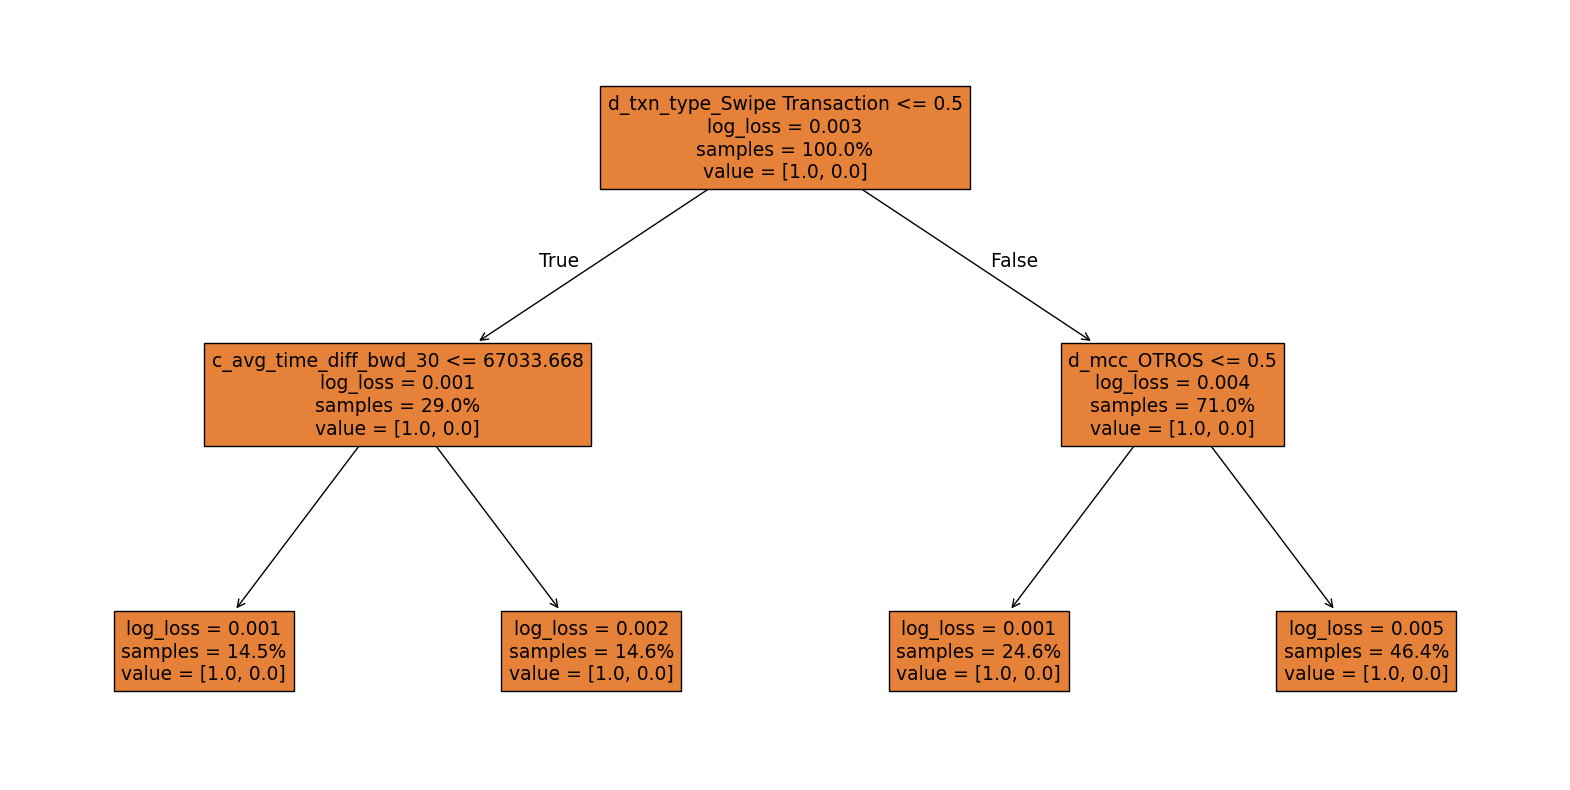

In [192]:
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=var, proportion=True)

### Validación del modelo 

In [193]:
Sn1 = valid[um+mc+vard+vart].copy()

In [194]:
Sn1[varoh] = oh.transform(dn.transform(Sn1[vard]))

In [195]:
Sn1 = Sn1[um+var+vart]

In [196]:
{'roc_auc_entrenamiento':roc_auc_score(y_score=dt.predict_proba(Sn[var])[:,1],y_true=Sn[vart[0]]),
 'roc_auc_validacion':roc_auc_score(y_score=dt.predict_proba(Sn1[var])[:,1],y_true=Sn1[vart[0]])
 }

{'roc_auc_entrenamiento': np.float64(0.6773772950672231),
 'roc_auc_validacion': np.float64(0.6805238163766977)}

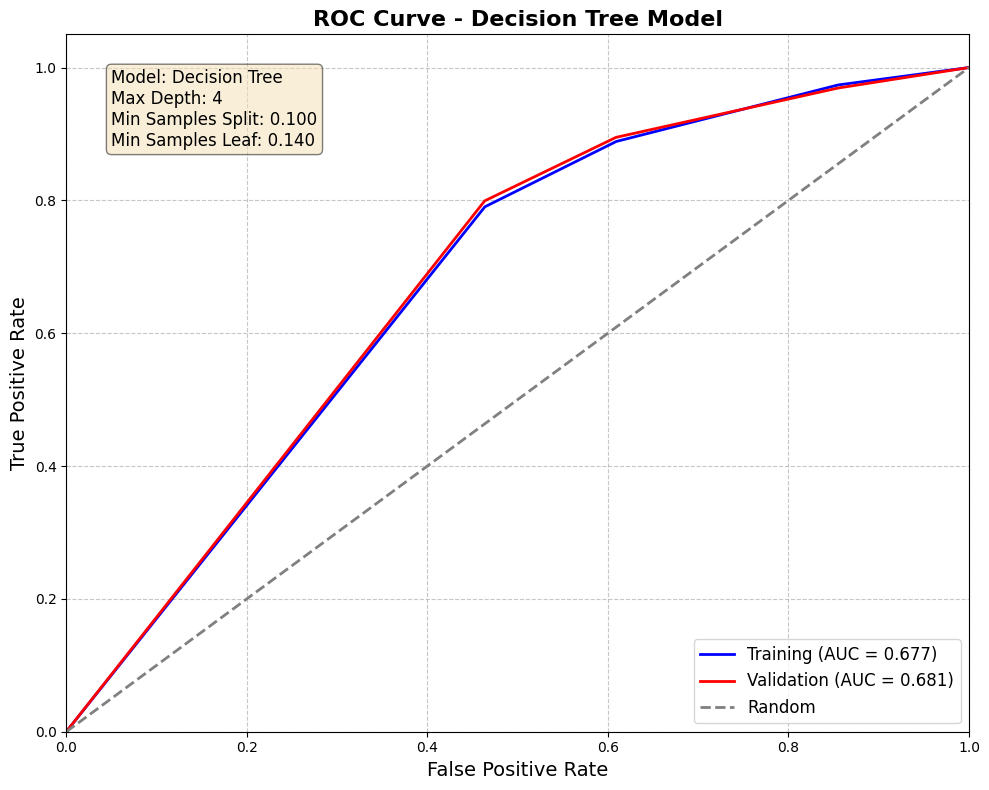

In [197]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for training and validation sets
y_train_true = Sn[vart[0]]
y_train_pred = dt.predict_proba(Sn[var])[:,1]

y_valid_true = Sn1[vart[0]]
y_valid_pred = dt.predict_proba(Sn1[var])[:,1]

# Calculate ROC curve points
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_pred)
fpr_valid, tpr_valid, _ = roc_curve(y_valid_true, y_valid_pred)

# Create a beautiful plot
plt.figure(figsize=(10, 8))

# Plot both curves
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Training (AUC = {roc_auc_score(y_train_true, y_train_pred):.3f})')
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, 
         label=f'Validation (AUC = {roc_auc_score(y_valid_true, y_valid_pred):.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - Decision Tree Model', fontsize=16, fontweight='bold')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)

# Add a text box with model details
textstr = '\n'.join([
    'Model: Decision Tree',
    f'Max Depth: {dt.max_depth}',
    f'Min Samples Split: {dt.min_samples_split:.3f}',
    f'Min Samples Leaf: {dt.min_samples_leaf:.3f}'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


## Uso del modelo 

In [200]:
Sn['node'] = dt.apply(Sn[var])
Sn['node'] = Sn['node'].apply(lambda x: f'N{x+1:02d}')

In [201]:
Sn1['node'] = dt.apply(Sn1[var])
Sn1['node'] = Sn1['node'].apply(lambda x: f'N{x+1:02d}')


In [202]:
Sn.head()

,id_txn,c_ratio_amount_prev_30,c_avg_time_diff_bwd_30,c_avg_amnt_bwd_30,d_txn_type_Swipe Transaction,d_state_OTROS,d_mcc_5411,d_mcc_5499,d_mcc_5541,d_mcc_OTROS,tgt_fraud,node
0,965-2,0.73,78938.00,57.39,1.00,1.00,0.00,0.00,1.00,0.00,0,N06
1,847-3,0.56,154966.00,44.89,1.00,1.00,0.00,0.00,0.00,1.00,0,N07
2,1150-1,0.04,28782.00,59.74,1.00,0.00,0.00,1.00,0.00,0.00,0,N06
3,1993-5,2.00,204430.00,70.76,0.00,1.00,0.00,0.00,0.00,1.00,0,N04
4,36-1,0.02,159532.00,31.84,0.00,0.00,0.00,0.00,0.00,1.00,0,N04


In [205]:
cubo = pd.concat([Sn.groupby(['node']+vart).agg({um[0]:'count'}).rename(columns={um[0]:'cases'}).assign(sample='train').reset_index(),
Sn1.groupby(['node']+vart).agg({um[0]:'count'}).rename(columns={um[0]:'cases'}).assign(sample='valid').reset_index()],ignore_index=True)

In [207]:
cubo.to_clipboard(index=False)